In [1]:
# load libraries
import os
import pandas as pd

# set paths
base_dir = '../data/Murine_Protein_Solubility_Data/processed'
demo_df = pd.read_csv(os.path.join(base_dir, 'demo_proteins_for_download.csv'))
aggrescan_df = pd.read_csv(os.path.join(base_dir, 'demo_aggrescan_scores_batches.csv'))

# parse the file name to extract canonical UniProt ID
aggrescan_df['Canonical_ID'] = aggrescan_df['pdb'].str.extract(r'AF-([A-Z0-9]+)-F1')

# create a canonical ID in demo subset
demo_df['Canonical_ID'] = demo_df['UniProt_ID'].str.split('-').str[0]

# merge data
merged_df = pd.merge(demo_df, aggrescan_df, on='Canonical_ID', how='left')
print(merged_df.head())
merged_df.to_csv(os.path.join(base_dir, 'demo_proteins_waggrescan.csv'), index=False)

                             GN_ID  Gene_Name  \
0  Serpina1a_sp|P07758|A1AT1_MOUSE  Serpina1a   
1  Serpina1c_sp|Q00896|A1AT3_MOUSE  Serpina1c   
2  Serpina3k_sp|P07759|SPA3K_MOUSE  Serpina3k   
3      Pdcd5_sp|P56812|PDCD5_MOUSE      Pdcd5   
4    S100a11_sp|P50543|S10AB_MOUSE    S100a11   

   log2FC(insoluble/soluble protein ratio)  -LOG10(P-VALUE)        Prefix  \
0                                 1.049360         3.103848  Serpina1a_sp   
1                                 1.034773         3.040414  Serpina1c_sp   
2                                 1.253885         2.759214  Serpina3k_sp   
3                                 1.476201         2.688373      Pdcd5_sp   
4                                 1.705127         2.487184    S100a11_sp   

  UniProt_ID UniProt_Name Direction Canonical_ID                        pdb  \
0     P07758  A1AT1_MOUSE        up       P07758  AF-P07758-F1-model_v4.pdb   
1     Q00896  A1AT3_MOUSE        up       Q00896  AF-Q00896-F1-model_v4.pdb   
2    

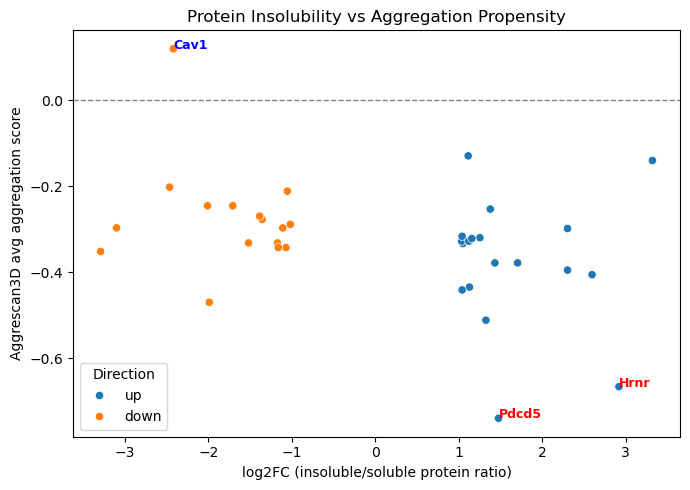

In [2]:
# Protein insolubility vs aggregation propensity
# load libraries
import matplotlib.pyplot as plt
import seaborn as sns

# identify outlier points
outlier_down = merged_df[
    (merged_df['Direction'] == 'down') &
    (merged_df['avg'] > 0)
]

outlier_up = merged_df[
    (merged_df['Direction'] == 'up') &
    (merged_df['avg'] < -0.6)
]

# plot
plt.figure(figsize=(7,5))
sns.scatterplot(
    x='log2FC(insoluble/soluble protein ratio)', 
    y='avg',
    hue='Direction',   # color points by up/down
    data=merged_df
)

# add outlier labels
for index, row in outlier_down.iterrows():
    plt.text(
        row['log2FC(insoluble/soluble protein ratio)'], 
        row['avg'], 
        row['Gene_Name'],
        color='blue',
        fontsize=9, fontweight='bold'
    )
for index, row in outlier_up.iterrows():
    plt.text(
        row['log2FC(insoluble/soluble protein ratio)'], 
        row['avg'], 
        row['Gene_Name'],
        color='red',
        fontsize=9, fontweight='bold'
    )
    
plt.xlabel('log2FC (insoluble/soluble protein ratio)')
plt.ylabel('Aggrescan3D avg aggregation score')
plt.title('Protein Insolubility vs Aggregation Propensity')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.legend(title="Direction")
plt.tight_layout()
plt.show()

In [13]:
# install missing module 
## run cell only once 
!pip install seaborn
!pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


full data: Spearman correlation: rho = -0.37, p = 0.0279
down: Spearman correlation: rho = -0.09, p = 0.728 (n=16)
up: Spearman correlation: rho = -0.16, p = 0.509 (n=19)


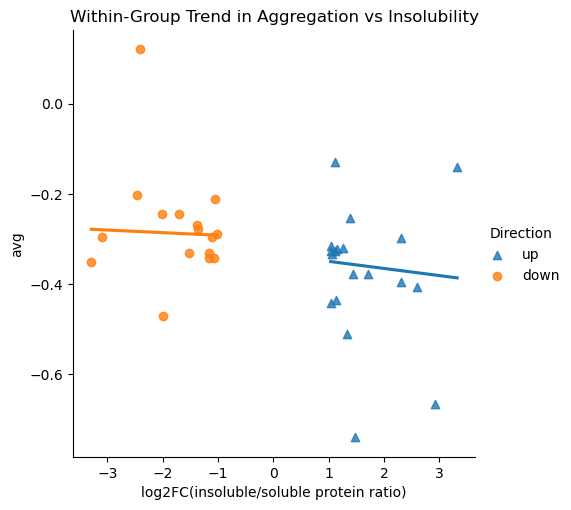

In [3]:
# Correlation analysis
from scipy.stats import spearmanr

# Spearman's rho is robust to non-normality
## for full dataset
valid = merged_df[['log2FC(insoluble/soluble protein ratio)', 'avg']].dropna()
rep, val = valid['log2FC(insoluble/soluble protein ratio)'], valid['avg']
rho, pval = spearmanr(rep, val)
print(f"full data: Spearman correlation: rho = {rho:.2f}, p = {pval:.3g}")

## for each subset 
for direction, subdf in merged_df.groupby('Direction'):
    valid = subdf[['log2FC(insoluble/soluble protein ratio)', 'avg']].dropna()
    rep = valid['log2FC(insoluble/soluble protein ratio)']
    val = valid['avg']
    if len(valid) > 1:  # need at least two data points!
        rho, pval = spearmanr(rep, val)
        print(f"{direction}: Spearman correlation: rho = {rho:.2f}, p = {pval:.3g} (n={len(valid)})")
    else:
        print(f"{direction}: Not enough data for correlation (n={len(valid)})")

# subset plot with lowess trend line
sns.lmplot(
    x='log2FC(insoluble/soluble protein ratio)', 
    y='avg',
    hue='Direction',
    data=merged_df,
    robust=True,
    markers=["^", "o"],
    ci=None
)
plt.title('Within-Group Trend in Aggregation vs Insolubility')
plt.show()

# SCanchi Notes

I was testing the hypothesis that proteins with higher insoluble ratio might also have higher aggregation propensity. When full data is used we get signficant results but this is false association since what we are capturing is the distinct groups for up vs down. When I looked at within group trends, this becomes clear. Based on the rho value, the association is not strong enough to be meaningful biologically amd the association is not significant. For this pilot dataset, the original hypothesis is not strongly supported. 

Next I wanted to test if there were group differences in aggregation scores. I used the Mann-Whitney U test which is robust to outliers and shape of data distribution. There is a statistically significant difference in aggregation scores between the up and downregulated protein groups.

Mann-Whitney U test: stat=87.0, p-value=0.03266


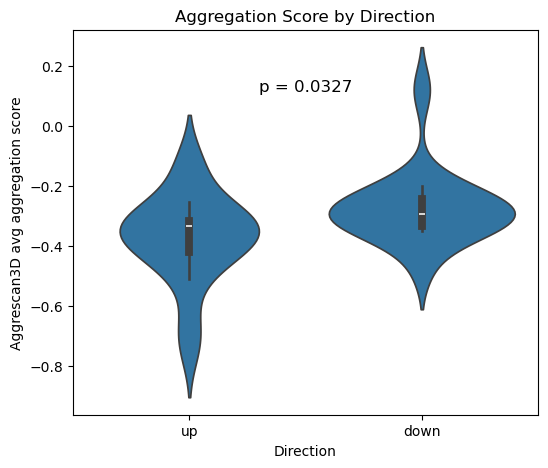

In [9]:
# Compare aggregation between groups

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# get scores for each group
up_scores = merged_df[merged_df['Direction']=='up']['avg'].dropna().astype(float)
down_scores = merged_df[merged_df['Direction']=='down']['avg'].dropna().astype(float)

# test for significance
stat, pval = mannwhitneyu(up_scores, down_scores, alternative='two-sided')
print(f"Mann-Whitney U test: stat={stat}, p-value={pval:.4g}")

# plot
plt.figure(figsize=(6,5))
sns.violinplot(
    x='Direction', 
    y='avg', 
    data=merged_df,
    inner='box'
)
plt.ylabel('Aggrescan3D avg aggregation score')
plt.title('Aggregation Score by Direction')
plt.text(
    0.5,                
    merged_df['avg'].max()*0.95,  
    f'p = {pval:.3g}',
    ha='center',
    fontsize=12
)
plt.show()

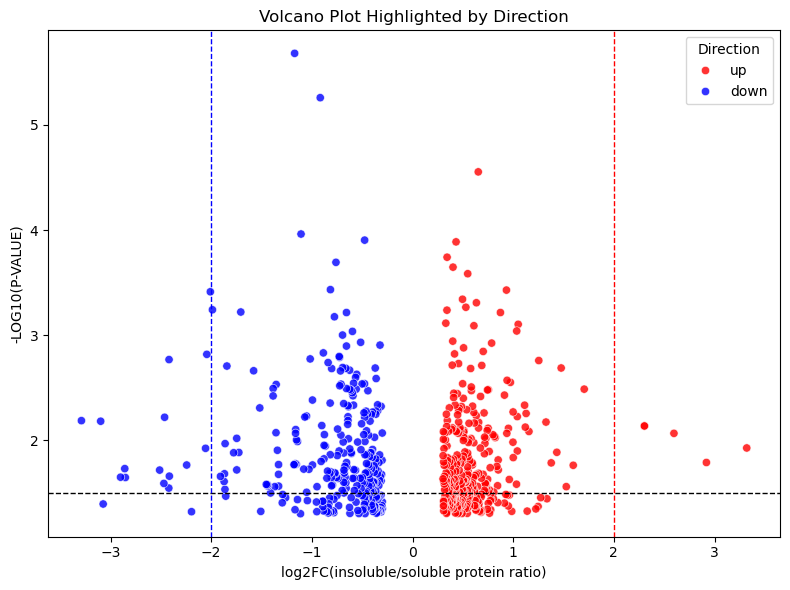

Mann-Whitney U test: stat=105952.00, p-value=1.052e-107


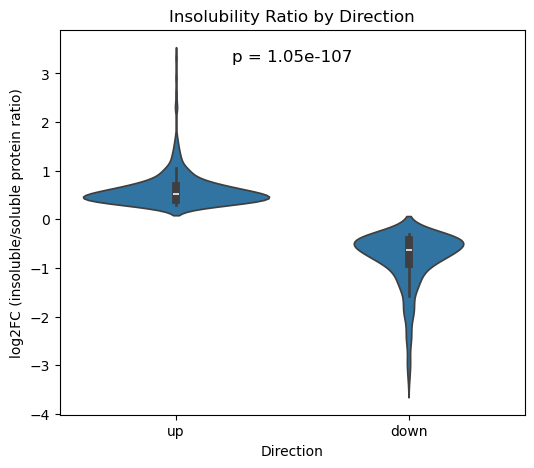

In [21]:
# Comparison of insolubility across groups
import os
import pandas as pd
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# set paths
base_dir = '../data/Murine_Protein_Solubility_Data/processed'
all_proteins = pd.read_csv(os.path.join(base_dir, 'all_enriched_proteins.csv'))

# label outliers
fc_extreme = 2                    
pval_extreme = 3                  

verySig = all_proteins[all_proteins['-LOG10(P-VALUE)'] > pval_extreme]
veryHighFC = all_proteins[all_proteins['log2FC(insoluble/soluble protein ratio)'].abs() > fc_extreme]
to_label = pd.concat([verySig, veryHighFC]).drop_duplicates()
#print(to_label[['Gene_Name', 'log2FC(insoluble/soluble protein ratio)', '-LOG10(P-VALUE)']])

# plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='log2FC(insoluble/soluble protein ratio)', 
    y='-LOG10(P-VALUE)', 
    hue='Direction',
    palette={'up': 'red', 'down': 'blue', 'not_significant': 'gray'},
    data=all_proteins,
    alpha=0.8
)
plt.axhline(1.5, color='k', linestyle='--', lw=1)
plt.axvline(2, color='red', linestyle='--', lw=1)
plt.axvline(-2, color='blue', linestyle='--', lw=1)

# label outliers
#for index, row in to_label.iterrows():
  #  plt.text(
  #      x=row['log2FC(insoluble/soluble protein ratio)'],
  #      y=row['-LOG10(P-VALUE)'],
  #    s=row['Gene_Name'],
  #      fontsize=8,
  #      ha='left' if row['log2FC(insoluble/soluble protein ratio)']>0 else 'right'
   # )
plt.title('Volcano Plot Highlighted by Direction')
plt.tight_layout()
plt.show()

# test for group significance
up_fc = all_proteins[all_proteins['Direction']=='up']['log2FC(insoluble/soluble protein ratio)'].dropna()
down_fc = all_proteins[all_proteins['Direction']=='down']['log2FC(insoluble/soluble protein ratio)'].dropna()

stat, pval = mannwhitneyu(up_fc, down_fc, alternative='two-sided')
print(f"Mann-Whitney U test: stat={stat:.2f}, p-value={pval:.4g}")

# plot insoluble fraction distribution
plt.figure(figsize=(6,5))
sns.violinplot(
    x='Direction',
    y='log2FC(insoluble/soluble protein ratio)',
    data=all_proteins, 
    inner='box'
)
plt.ylabel('log2FC (insoluble/soluble protein ratio)')
plt.title('Insolubility Ratio by Direction')

# Annotate with p-value
plt.text(
    0.5, all_proteins['log2FC(insoluble/soluble protein ratio)'].max()*0.98,
    f'p = {pval:.3g}', ha='center', fontsize=12
)
plt.show()

# SCanchi Notes

Since the demo proteins set is small (20/group), I also wanted to examine the distribution and test for group differences in the insoluble ratio on the full set. I initially wanted to annotate the volcano plot for outliers i.e. extreme values for either pval or FC but since there are protein repetitions across groups I decided against it. This might be because the data is collapsed across experimental groups and without additional metadata context it is difficult to interpret.

The statistical difference between the groups confirms the original separation of groups which was on insolubility properties. 
